This is a model from https://www.kaggle.com/code/nakulsingh1289/face-expression-detection-from-scratch/notebook

modified to meet a more modern keras style and improved coding style

## Image augmentation using keras ImageDataGenerator

In [1]:
# building data generator
from keras.preprocessing.image import ImageDataGenerator

base_path = "./images/"
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(48, 48),
    subset="training",
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    base_path + 'train',
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

test_data_generator = test_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
)


2022-10-23 16:36:50.400116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 16:36:50.495036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 16:36:50.874642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.1/targets/x86_64-linux/lib:/usr/local/cuda-11.7/targets/x86_64-linux/lib
2022-10-23 16:36:50.874684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import AUC, CategoricalAccuracy, Precision, Recall

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential([

    # 1 - Convolution
    Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 2nd Convolution layer
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 3rd Convolution layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 4th Convolution layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flattening
    Flatten(),

    # Fully connected layer 1st layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Fully connected layer 2nd layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25)
])

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[
    CategoricalAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),  
    AUC(name='auc'),
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

2022-10-23 16:36:51.915336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:36:51.933630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:36:51.933790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:36:51.934108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# number of epochs to train the NN
epochs = 100

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/100


2022-10-23 16:36:53.575794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


358/360 [============================>.] - ETA: 0s - loss: 2.0527 - accuracy: 0.2116 - precision: 0.2190 - recall: 0.0359 - auc: 0.6118
Epoch 1: val_accuracy improved from -inf to 0.24757, saving model to model_weights.h5
360/360 [==============================] - 10s 22ms/step - loss: 2.0519 - accuracy: 0.2120 - precision: 0.2193 - recall: 0.0359 - auc: 0.6121 - val_loss: 1.8599 - val_accuracy: 0.2476 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6492
Epoch 2/100
359/360 [============================>.] - ETA: 0s - loss: 1.9399 - accuracy: 0.2269 - precision: 0.2557 - recall: 0.0308 - auc: 0.6392
Epoch 2: val_accuracy improved from 0.24757 to 0.25069, saving model to model_weights.h5
360/360 [==============================] - 7s 21ms/step - loss: 1.9393 - accuracy: 0.2271 - precision: 0.2566 - recall: 0.0309 - auc: 0.6393 - val_loss: 1.8079 - val_accuracy: 0.2507 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6643
Epoch 3/100
359/360 [===========

In [4]:
from matplotlib import pyplot as plt

# visualise training and testing accuracy and loss


def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    auc = history.history['auc']
    val_auc = history.history['val_auc']

    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, auc, 'b', label='Training AUC')
    plt.plot(epochs, val_auc, 'r', label='Validation AUC')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precision, 'b', label='Training Precision')
    plt.plot(epochs, val_precision, 'r', label='Validation Precision')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

    plt.figure(figsize=(24, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, recall, 'b', label='Training Recall')
    plt.plot(epochs, val_recall, 'r', label='Validation Recall')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# print best epoch with best accuracy on validation


def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    valid_auc = history.history['val_auc']
    valid_precision = history.history['val_precision']
    valid_recall = history.history['val_recall']
    
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)

    best_epoch_auc = valid_auc.index(max(valid_auc)) + 1
    best_auc = max(valid_auc)

    best_epoch_precision = valid_precision.index(max(valid_precision)) + 1
    best_precision = max(valid_precision)

    best_epoch_recall = valid_recall.index(max(valid_recall)) + 1
    best_recall = max(valid_recall)

    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format(
        best_acc, best_epoch))
    print('Best Validation AUC {:0.5f}, is for epoch {}'.format(
        best_auc, best_epoch_auc))
    print('Best Validation Precision {:0.5f}, is for epoch {}'.format(
        best_precision, best_epoch_auc))
    print('Best Validation Recall {:0.5f}, is for epoch {}'.format(
        best_recall, best_epoch_auc))


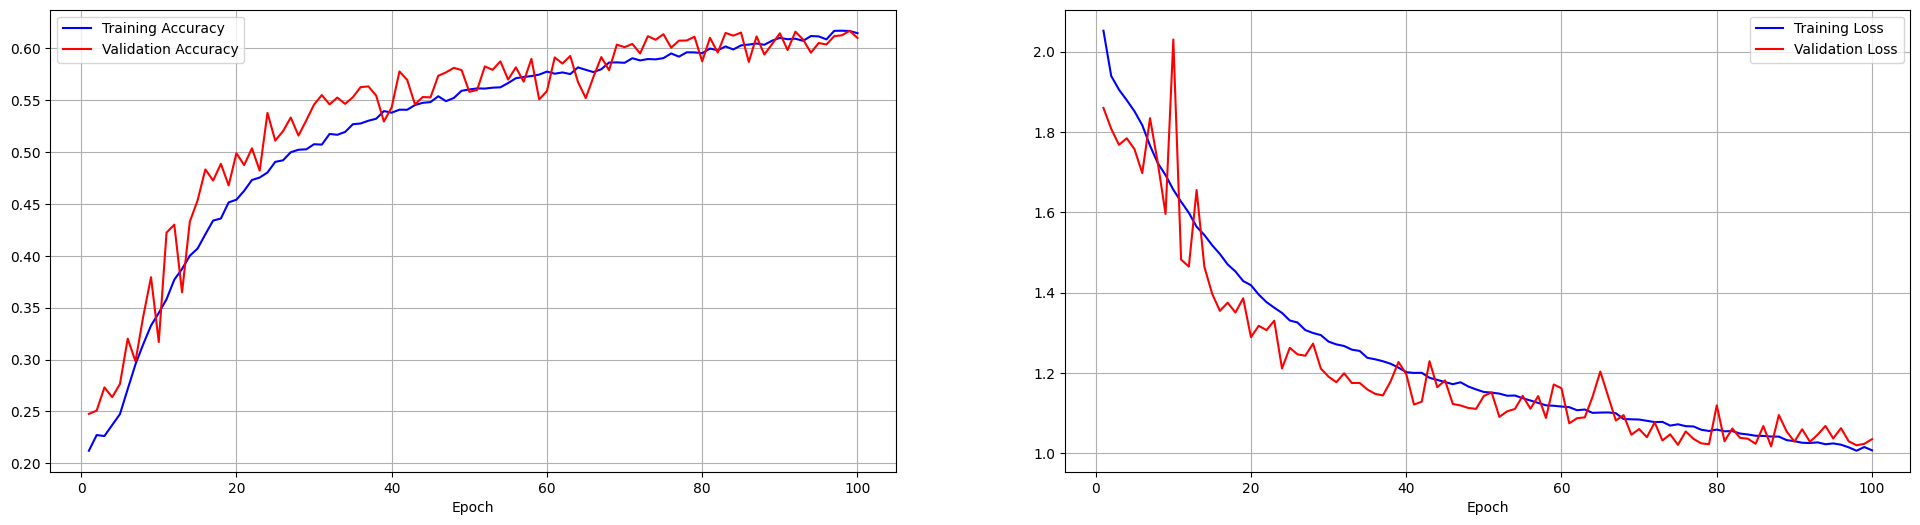

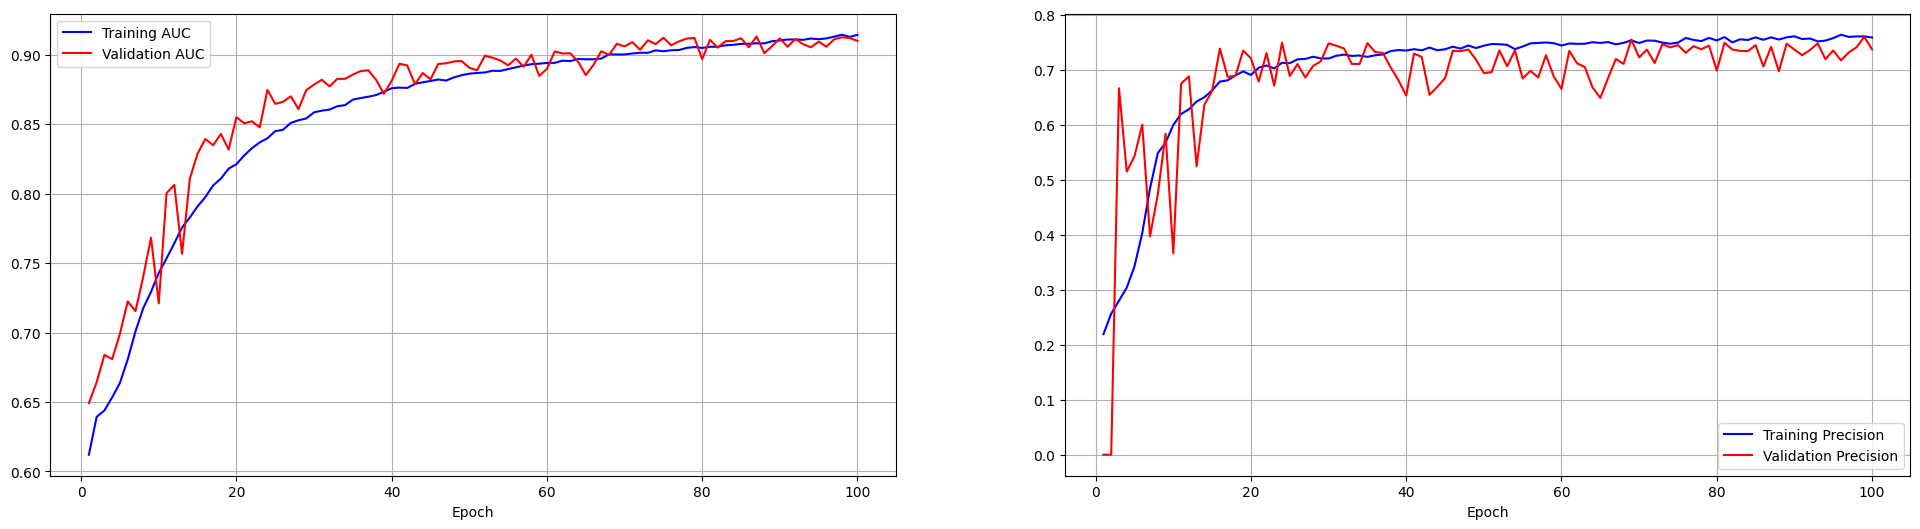

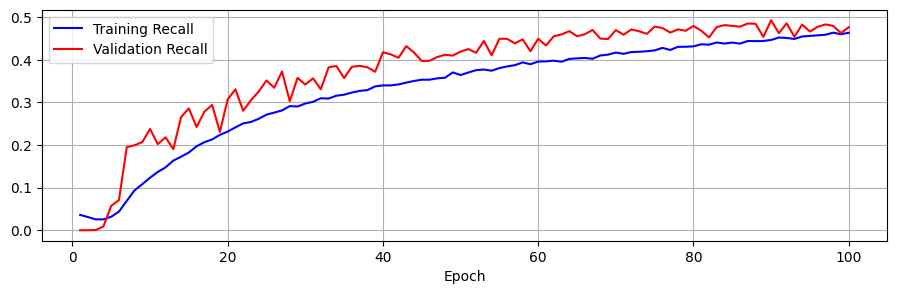

Best Validation Accuracy Score 0.61701, is for epoch 99
Best Validation AUC 0.91318, is for epoch 87
Best Validation Precision 0.76027, is for epoch 87
Best Validation Recall 0.49271, is for epoch 87


In [5]:
plot_results(history)
get_best_epoch(history)

In [6]:
model.evaluate(test_data_generator)


111/111 [==============================] - 1s 9ms/step - loss: 1.0194 - accuracy: 0.6204 - precision: 0.7494 - recall: 0.4901 - auc: 0.9130


[1.0194482803344727,
 0.620435893535614,
 0.7494049072265625,
 0.4900934100151062,
 0.9129813313484192]

In [7]:
import numpy as np;
predictions = np.argmax(model.predict(test_data_generator),axis=1)

111/111 [==============================] - 1s 7ms/step


In [8]:
test_data_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}